In [294]:
import numpy as np
import pandas as pd
import networkx as nx
from fa2 import ForceAtlas2
import graspy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Load Data

In [280]:
path = './recipes.csv'
with open('./.plotly_key.cred') as f:
    plotly_user,plotly_key = [l.strip().split('=')[1] for l in f.readlines()]
data = pd.read_csv(path, sep=',', encoding = "utf-8")

In [12]:
nodes = data.Name.values
alcohols = [[w.lower() for w in v.split('; ')] if type(v) == str else [v] for v in data.Alcohol.values]
ingredients = [[w.lower() for w in v.split('; ')] if type(v) == str else [''] for v in data.Ingredients.values]
ingredients_total = [i + j if not j == [''] else i for i,j in zip(alcohols, ingredients)]

### Initial Ingredient Network and Plots

In [317]:
G = nx.DiGraph()
G.add_nodes_from(nodes)
for n,a,i in zip(nodes,alcohols,ingredients):
    G.nodes[n]['Alcohols'] = a
    G.nodes[n]['Ingredients'] = i
    
for n1,a1,i1 in zip(nodes,alcohols,ingredients):
    for n2,a2,i2 in zip(nodes,alcohols,ingredients):
        mutual_alc = (len(a1) + len(set(a1) & set(a2))) / (len(a2) + len(a1))
        mutual_ing = (len(i1) + len(set(i1) & set(i2))) / (len(i2) + len(i1))
        if len(set(a1) & set(a2)) + len(set(i1) & set(i2)) == 0:
            continue
        G.add_edge(n1,n2,weight=10*mutual_alc + 1*mutual_ing)

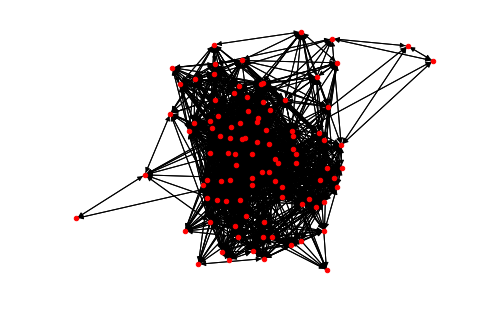

In [242]:
nx.draw(G,node_size=20)

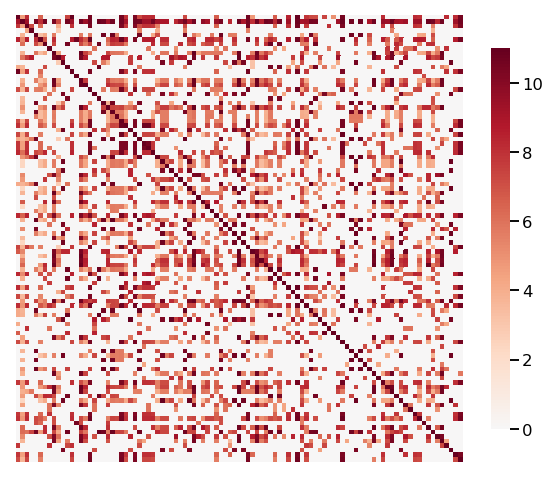

In [243]:
A = nx.to_numpy_matrix(G)
graspy.plot.heatmap(A)

In [245]:
from sklearn.cluster import KMeans

In [318]:
A = nx.to_numpy_matrix(G)
ase = graspy.embed.AdjacencySpectralEmbed()
Xhat = ase.fit_transform(A)[0]

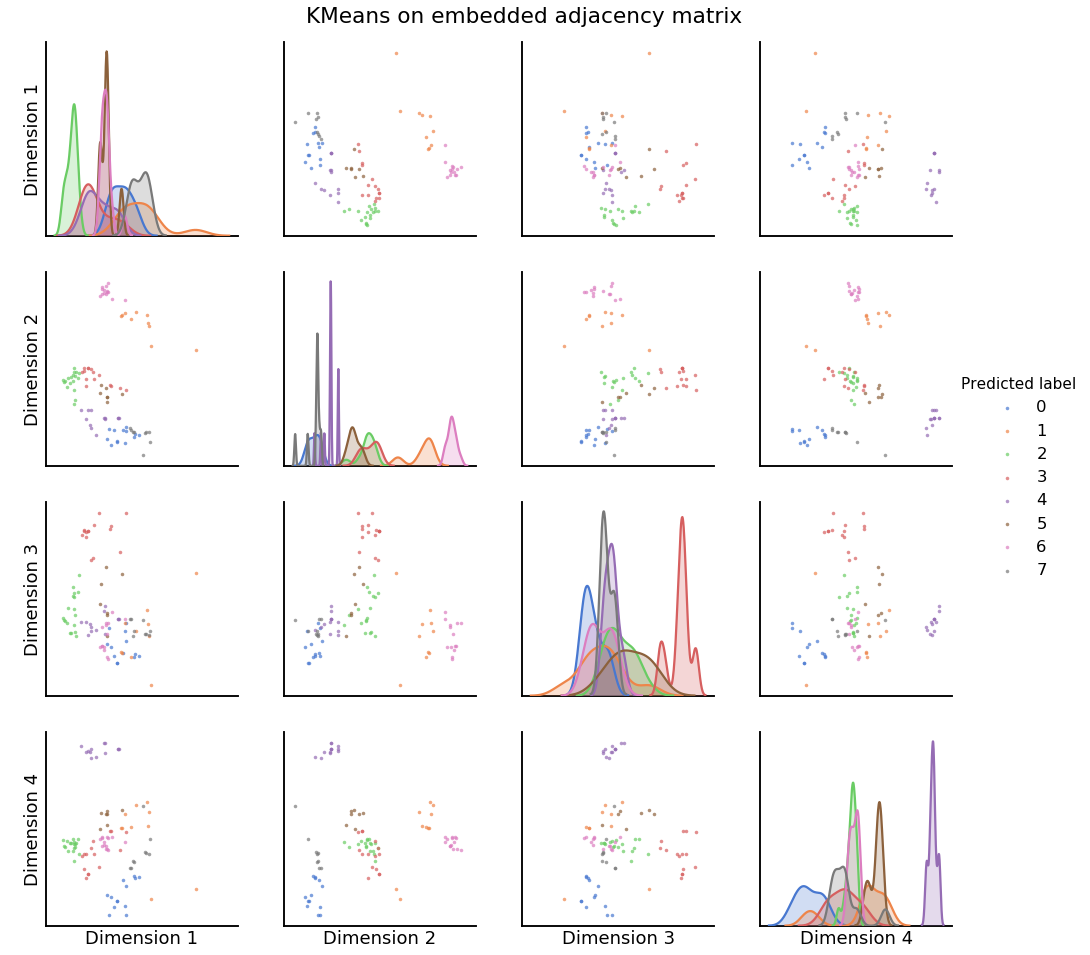

In [319]:
labels_kmeans = KMeans().fit_predict(Xhat)
graspy.plot.pairplot(Xhat,
         labels=labels_kmeans,
         title='KMeans on embedded adjacency matrix',
         legend_name='Predicted label',
         height=3.5,
         palette='muted')

In [320]:
idxs = np.argsort(labels_kmeans)
A = A[idxs,:][:,idxs]

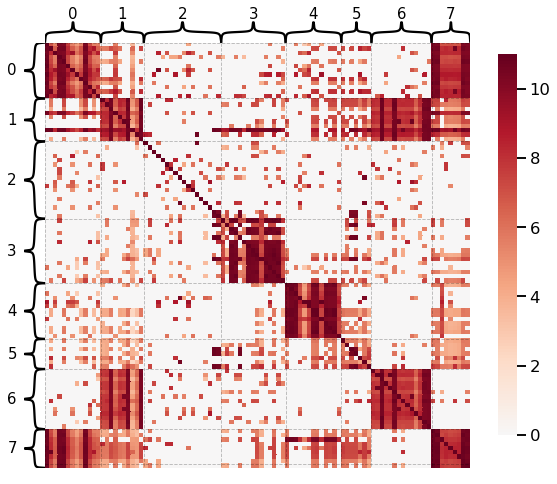

In [321]:
title = 'Sorted Graph by Labels'
fig = graspy.plot.heatmap(A, title=title, inner_hier_labels=labels_kmeans[idxs])

In [261]:
forceatlas2 = ForceAtlas2(scalingRatio=1,
                          strongGravityMode=False,
                          gravity=30)

pos = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1187.96it/s]


BarnesHut Approximation  took  0.27  seconds
Repulsion forces  took  1.21  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.07  seconds


C:\Users\Ronan Perry\Miniconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


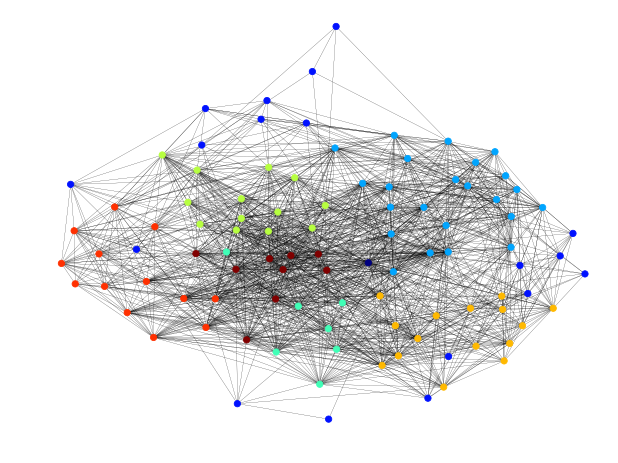

In [262]:
plt.figure(figsize=(8,6))
nx.draw(G ,pos,node_size=40,width=0.1, linewidths=0.8, zoom=1.5,node_color=labels_kmeans+1,cmap=plt.cm.jet, arrows=False)
#plt.gca().collections[0].set_edgecolor("#000000") 
#plt.savefig('./network.png',bbox_inches='tight')
plt.show()

In [341]:
terms = {i:[] for i in range(max(labels_kmeans) + 1)}
counts = {i:0 for i in range(max(labels_kmeans) + 1)}
for label,alc in zip(labels_kmeans, alcohols):
    terms[label] += alc
    counts[label] += 1

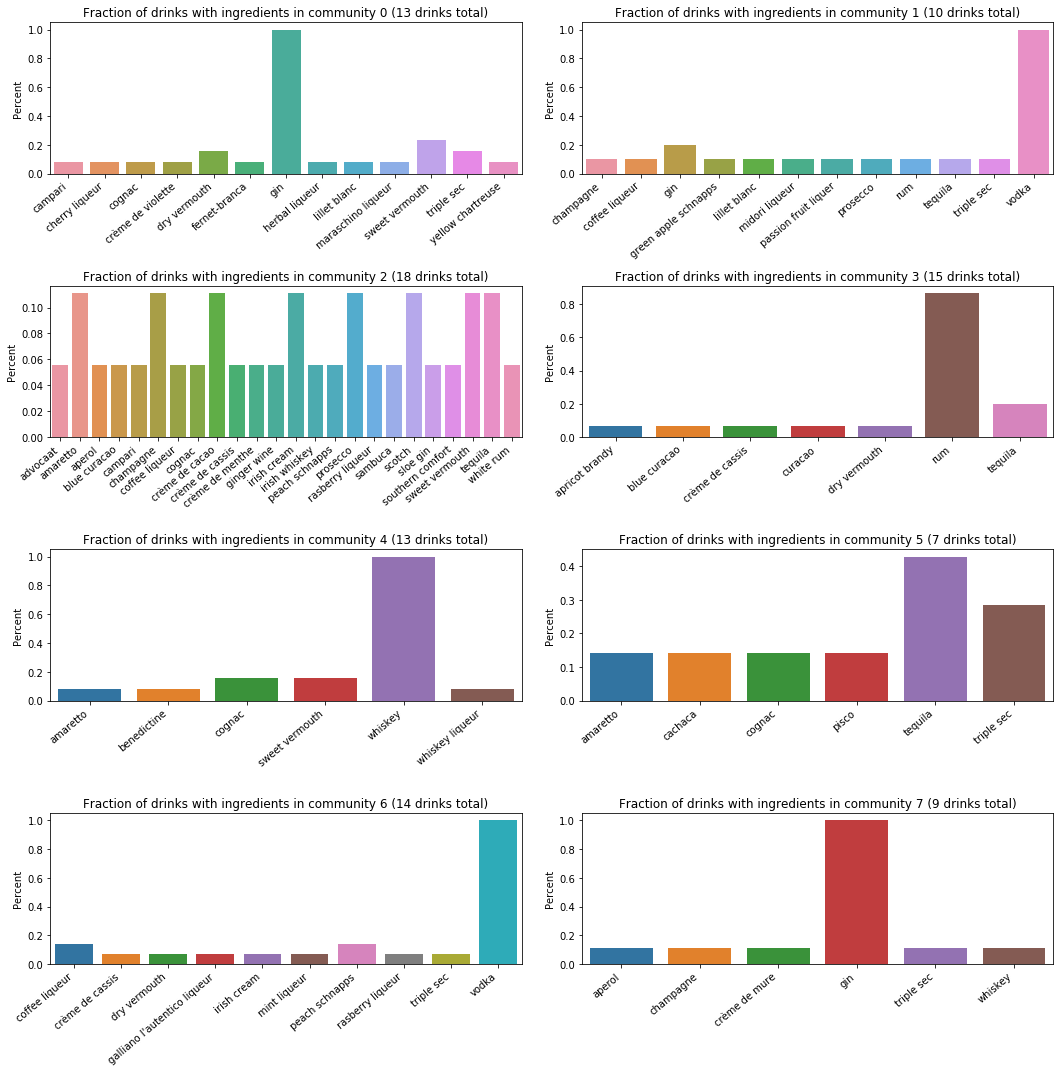

In [395]:
plt.figure(figsize=(15,15))
for i in range(max(labels_kmeans) + 1):
    plt.subplot(4,2,i+1)
    keys, counts2 = np.unique(terms[i],return_counts=True)
    ax = sns.barplot(x=keys, y=counts2/counts[i])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.ylabel('Percent')
    plt.title('Fraction of drinks with ingredients in community %d (%d drinks total)' % (i, counts[i]))
plt.tight_layout()
plt.show()

In [269]:
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

In [281]:
plotly.tools.set_credentials_file(username=plotly_user, api_key=plotly_key)

In [396]:
dmin=1
ncenter='Long Island Iced Tea'
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

p=nx.single_source_shortest_path_length(G,ncenter)

In [402]:
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

In [ ]:
node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Jet',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Edge Weight',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

In [186]:
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    
for i, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=labels_kmeans[i]
    node_info = 'Name: %r <br> Alcohols: %r <br> Ingredients: %r' % (nodes[i],alcohols[i], ingredients[i])
    node_trace['text']+=tuple([node_info])

In [187]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Recipe Network, Colored by KMeans clustering',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    #text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

py.iplot(fig, filename='recipe_network')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rflperry/0 or inside your plot.ly account where it is named 'networkx'


C:\Users\Ronan Perry\Miniconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [184]:
layout = dict(title='<br>Recipe Network, Colored by KMeans clustering',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
fig = dict(data=[edge_trace, node_trace], layout=layout)